# Анализ эксперимента по определению setpoint от 16 января 2026 г

In [4]:
import matplotlib.pyplot as plt

from pathlib import Path
from nn_laser_stabilizer.experiment.config import load_config

EXPERIMENT_DIR = "setpoint_determination/2026-01-16_20-32-47" # 2026-01-16_20-36-02
EXPERIMENT_DIR_PATH = Path(f"../experiments/{EXPERIMENT_DIR}")

ENV_LOG_PATH = EXPERIMENT_DIR_PATH / "connection.log"

CONFIG_PATH = EXPERIMENT_DIR_PATH / "config.yaml"
config = load_config(CONFIG_PATH)
print(f"Эксперимент: {config.experiment_name}")

Эксперимент: setpoint_determination


In [5]:
import re
import pandas as pd

def parse_env_logs(file_path: str | Path) -> pd.DataFrame: 
    pid_send_pattern = re.compile(
        r"\[PID\]\s+"
        r"send:\s+"
        r"kp=(?P<kp>-?\d+\.\d+)\s+"
        r"ki=(?P<ki>-?\d+\.\d+)\s+"
        r"kd=(?P<kd>-?\d+\.\d+)\s+"
        r"control_min=(?P<control_min>\d+)\s+"
        r"control_max=(?P<control_max>\d+)\s+"
        r"setpoint=(?P<setpoint>\d+)"
    )
    
    pid_read_pattern = re.compile(
        r"\[PID\]\s+"
        r"read:\s+"
        r"process_variable=(?P<process_variable>-?\d+\.\d+)\s+"
        r"control_output=(?P<control_output>-?\d+\.\d+)"
    )
    
    conn_rows = []
    connection_step = 0
    
    pending_send = None
    line_number = 0  
    
    with open(file_path, 'r') as f:
        for raw_line in f:
            line_number += 1
            line = raw_line.strip()
            if not line:
                continue
              
            m = pid_send_pattern.match(line)
            if m:
                pending_send = {
                    'kp': float(m.group('kp')),
                    'ki': float(m.group('ki')),
                    'kd': float(m.group('kd')),
                    'control_min': int(m.group('control_min')),
                    'control_max': int(m.group('control_max')),
                    'setpoint': int(m.group('setpoint')),
                    'line': line_number,
                }
                continue
            
            m = pid_read_pattern.match(line)
            if m:
                if pending_send is None:
                    raise ValueError(
                        f"PID READ without matching SEND at line {line_number}: {raw_line!r}"
                    )
                
                conn_rows.append({
                    'Connection step': connection_step,
                    'Type': 'exchange',
                    'Kp': pending_send['kp'],
                    'Ki': pending_send['ki'],
                    'Kd': pending_send['kd'],
                    'Control min': pending_send['control_min'],
                    'Control max': pending_send['control_max'],
                    'Process variable': float(m.group('process_variable')),
                    'Control output': float(m.group('control_output')),
                    'Setpoint': pending_send['setpoint']
                })
                connection_step += 1
                continue

    connection_df = pd.DataFrame(conn_rows)
    return connection_df

connection_df = parse_env_logs(ENV_LOG_PATH)
print(f"Загружено {len(connection_df)} записей")

Загружено 6000 записей


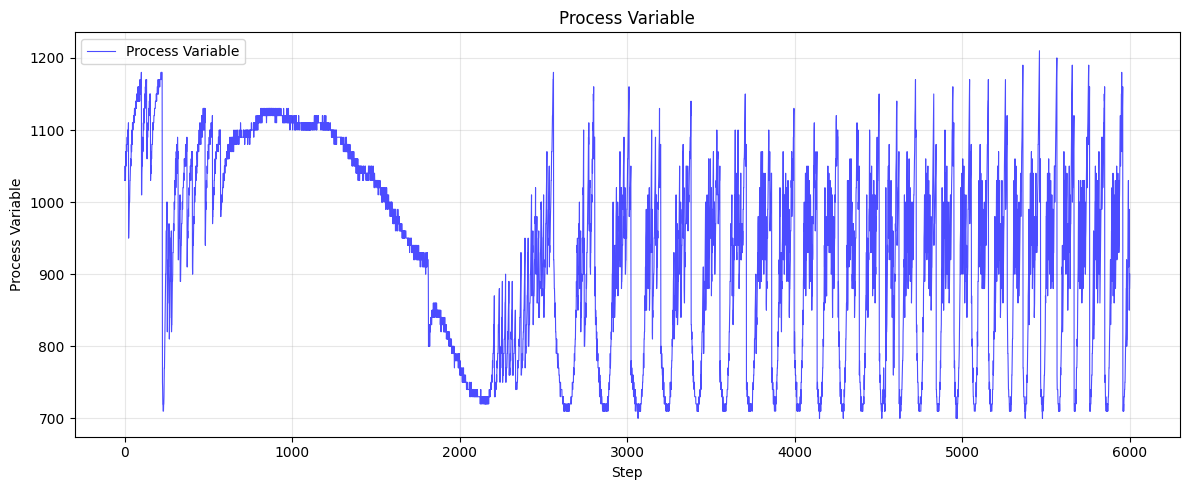

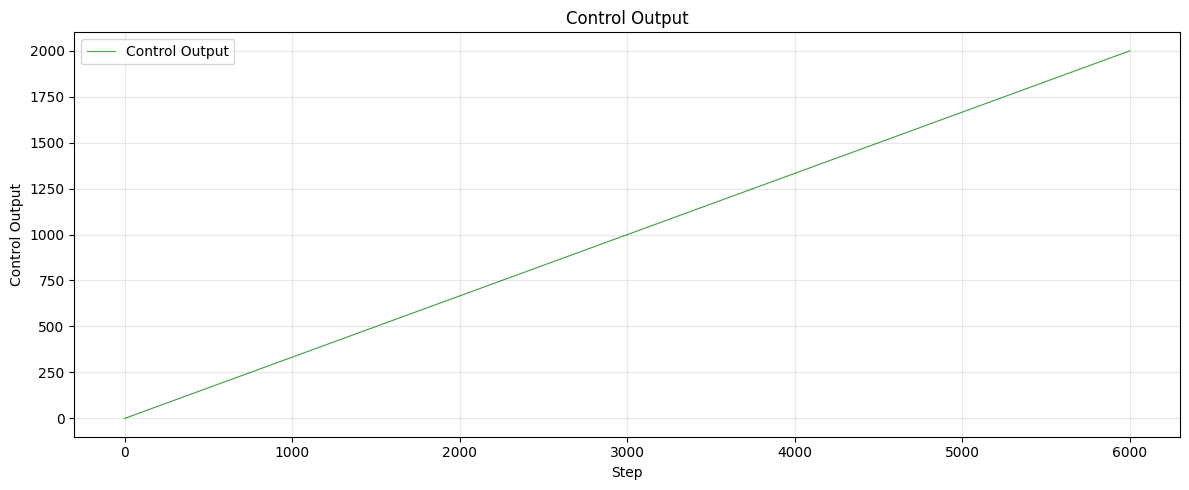

In [6]:
plt.figure(figsize=(12, 5))
plt.plot(connection_df['Connection step'], connection_df['Process variable'], 'b-', alpha=0.7, linewidth=0.8, label='Process Variable')

plt.title('Process Variable')
plt.xlabel('Step')
plt.ylabel('Process Variable')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(connection_df['Connection step'], connection_df['Control output'], 'g-', alpha=0.7, linewidth=0.8, label='Control Output')

plt.title('Control Output')
plt.xlabel('Step')
plt.ylabel('Control Output')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()